In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Test"

cuda


# Import Data

In [5]:

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform_val) # img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, model):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.model_fe = nn.Sequential(*list(model.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=147456, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.model_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(model = models.densenet121(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [15]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 7543684


# Train Model

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


train loss:  1.0733390231139424
Val loss:  1.4636258503665094
train accuracy:  0.44390715667311414
Val accuracy:  0.391304347826087
Best model at the moment with Val_acc 39.13, saving...
Current time: 2.232 minutes. Time expected till completion: 220.921 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


train loss:  1.348548302221575
Val loss:  1.6787892839182978
train accuracy:  0.5019342359767892
Val accuracy:  0.3739130434782609
Current time: 4.214 minutes. Time expected till completion: 206.500 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.6519188037001649
Val loss:  1.6173748140749724
train accuracy:  0.4825918762088975
Val accuracy:  0.43478260869565216
Best model at the moment with Val_acc 43.48, saving...
Current time: 6.195 minutes. Time expected till completion: 200.291 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.5930553135855443
Val loss:  25.131626626719598
train accuracy:  0.48065764023210833
Val accuracy:  0.3130434782608696
Current time: 8.169 minutes. Time expected till completion: 196.063 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  2.0025179426490225
Val loss:  1.055839939609818
train accuracy:  0.48065764023210833
Val accuracy:  0.5478260869565217
Best model at the moment with Val_acc 54.78, saving...
Current time: 10.149 minutes. Time expected till completion: 192.823 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.863104730542088
Val loss:  1.851061893546063
train accuracy:  0.504835589941973
Val accuracy:  0.4956521739130435
Current time: 12.120 minutes. Time expected till completion: 189.881 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.8674750948897645
Val loss:  5.612254254714302
train accuracy:  0.4758220502901354
Val accuracy:  0.3652173913043478
Current time: 14.088 minutes. Time expected till completion: 187.171 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.1603052111439824
Val loss:  0.9411673909944037
train accuracy:  0.4758220502901354
Val accuracy:  0.5478260869565217
Current time: 16.056 minutes. Time expected till completion: 184.639 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  2.0482864029979337
Val loss:  2.2951892811319103
train accuracy:  0.49032882011605416
Val accuracy:  0.40869565217391307
Current time: 18.024 minutes. Time expected till completion: 182.239 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  2.1518115019914377
Val loss:  2.4875168909197267
train accuracy:  0.5058027079303675
Val accuracy:  0.4956521739130435
Current time: 19.992 minutes. Time expected till completion: 179.926 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.115063589246407
Val loss:  10.8463820664779
train accuracy:  0.4835589941972921
Val accuracy:  0.3739130434782609
Current time: 21.959 minutes. Time expected till completion: 177.669 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  2.1746819344722095
Val loss:  2.3917879597000455
train accuracy:  0.5096711798839458
Val accuracy:  0.4782608695652174
Current time: 23.928 minutes. Time expected till completion: 175.474 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.14787842958786
Val loss:  5.5935797110847805
train accuracy:  0.5125725338491296
Val accuracy:  0.5304347826086957
Current time: 25.899 minutes. Time expected till completion: 173.323 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.7148685455610488
Val loss:  8.24903701155082
train accuracy:  0.5367504835589942
Val accuracy:  0.45217391304347826
Current time: 27.870 minutes. Time expected till completion: 171.203 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.8875596952958777
Val loss:  1.9505079414533533
train accuracy:  0.4951644100580271
Val accuracy:  0.46956521739130436
Current time: 29.841 minutes. Time expected till completion: 169.099 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.6176531661527702
Val loss:  3.5612624044003693
train accuracy:  0.5338491295938105
Val accuracy:  0.45217391304347826
Current time: 31.812 minutes. Time expected till completion: 167.011 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.8774615335251192
Val loss:  2.2388417435728987
train accuracy:  0.5415860735009671
Val accuracy:  0.4956521739130435
Current time: 33.782 minutes. Time expected till completion: 164.937 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.8991743845602127
Val loss:  4.9960544669109845
train accuracy:  0.5
Val accuracy:  0.3739130434782609
Current time: 35.752 minutes. Time expected till completion: 162.869 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.7374201963882627
Val loss:  1.9557158563448036
train accuracy:  0.5309477756286267
Val accuracy:  0.40869565217391307
Current time: 37.718 minutes. Time expected till completion: 160.799 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  2.079905301274829
Val loss:  2.9397672736126443
train accuracy:  0.5415860735009671
Val accuracy:  0.45217391304347826
Current time: 39.686 minutes. Time expected till completion: 158.746 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.033952168270052
Val loss:  2.7775735253873077
train accuracy:  0.5193423597678917
Val accuracy:  0.43478260869565216
Current time: 41.654 minutes. Time expected till completion: 156.698 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  1.9964988285844976
Val loss:  2.8781214845326284
train accuracy:  0.49709864603481624
Val accuracy:  0.4260869565217391
Current time: 43.620 minutes. Time expected till completion: 154.652 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.810538064003913
Val loss:  4.982611376306285
train accuracy:  0.5096711798839458
Val accuracy:  0.46956521739130436
Current time: 45.586 minutes. Time expected till completion: 152.614 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  2.103237805070222
Val loss:  2.2280567469804184
train accuracy:  0.4835589941972921
Val accuracy:  0.4956521739130435
Current time: 47.552 minutes. Time expected till completion: 150.580 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.6377828593872041
Val loss:  4.608631735262663
train accuracy:  0.5309477756286267
Val accuracy:  0.45217391304347826
Current time: 49.519 minutes. Time expected till completion: 148.557 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  2.0224064734099683
Val loss:  3.64294549278591
train accuracy:  0.4709864603481625
Val accuracy:  0.30434782608695654
Current time: 51.486 minutes. Time expected till completion: 146.537 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.9105256343074863
Val loss:  34.04846750497818
train accuracy:  0.49709864603481624
Val accuracy:  0.46956521739130436
Current time: 53.454 minutes. Time expected till completion: 144.524 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  2.0639679308019656
Val loss:  8.485042922393136
train accuracy:  0.5154738878143134
Val accuracy:  0.3826086956521739
Current time: 55.422 minutes. Time expected till completion: 142.514 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.2884069255533372
Val loss:  4.8058122598606605
train accuracy:  0.5019342359767892
Val accuracy:  0.33043478260869563
Current time: 57.391 minutes. Time expected till completion: 140.509 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  2.3140087026519054
Val loss:  6.77034854059634
train accuracy:  0.47775628626692457
Val accuracy:  0.3826086956521739
Current time: 59.359 minutes. Time expected till completion: 138.505 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  2.324239071321672
Val loss:  9.898426928727524
train accuracy:  0.4864603481624758
Val accuracy:  0.5478260869565217
Current time: 61.326 minutes. Time expected till completion: 136.500 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.8276015108728663
Val loss:  2.8470072150230408
train accuracy:  0.4961315280464217
Val accuracy:  0.4608695652173913
Current time: 63.293 minutes. Time expected till completion: 134.497 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  1.927451274035286
Val loss:  3.732477431193642
train accuracy:  0.5058027079303675
Val accuracy:  0.4260869565217391
Current time: 65.262 minutes. Time expected till completion: 132.501 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.826530483059542
Val loss:  4.061786386241083
train accuracy:  0.5058027079303675
Val accuracy:  0.3826086956521739
Current time: 67.229 minutes. Time expected till completion: 130.503 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  2.088643440310222
Val loss:  2.6192800221235855
train accuracy:  0.5145067698259188
Val accuracy:  0.4260869565217391
Current time: 69.195 minutes. Time expected till completion: 128.505 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  1.935231985045125
Val loss:  192.13765007516614
train accuracy:  0.5319148936170213
Val accuracy:  0.40869565217391307
Current time: 71.164 minutes. Time expected till completion: 126.514 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.8181955753349923
Val loss:  2.4974784643753716
train accuracy:  0.5502901353965184
Val accuracy:  0.5652173913043478
Best model at the moment with Val_acc 56.52, saving...
Current time: 73.137 minutes. Time expected till completion: 124.531 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.8557680450970706
Val loss:  23.854523539391938
train accuracy:  0.5357833655705996
Val accuracy:  0.4608695652173913
Current time: 75.106 minutes. Time expected till completion: 122.542 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.6293152788927783
Val loss:  16.987648043425185
train accuracy:  0.5522243713733076
Val accuracy:  0.4956521739130435
Current time: 77.074 minutes. Time expected till completion: 120.552 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  2.1121597548287427
Val loss:  10.021132381066032
train accuracy:  0.5183752417794971
Val accuracy:  0.45217391304347826
Current time: 79.040 minutes. Time expected till completion: 118.560 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  1.5861171162757046
Val loss:  2.431128336035687
train accuracy:  0.5667311411992263
Val accuracy:  0.4260869565217391
Current time: 81.008 minutes. Time expected till completion: 116.572 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  1.8546242315577846
Val loss:  3.371983951066985
train accuracy:  0.5725338491295938
Val accuracy:  0.4608695652173913
Current time: 82.972 minutes. Time expected till completion: 114.581 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  1.588697585997368
Val loss:  1.9072955057186924
train accuracy:  0.5599613152804642
Val accuracy:  0.4434782608695652
Current time: 84.952 minutes. Time expected till completion: 112.611 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  1.2588766540618652
Val loss:  17.116439750228405
train accuracy:  0.5909090909090909
Val accuracy:  0.391304347826087
Current time: 86.922 minutes. Time expected till completion: 110.628 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


train loss:  2.0089104404417184
Val loss:  4.004249783572943
train accuracy:  0.5464216634429401
Val accuracy:  0.43478260869565216
Current time: 88.934 minutes. Time expected till completion: 108.698 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


train loss:  1.4517629850273899
Val loss:  5.567689351251592
train accuracy:  0.5464216634429401
Val accuracy:  0.41739130434782606
Current time: 91.013 minutes. Time expected till completion: 106.841 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


train loss:  1.787163825882297
Val loss:  3.1359596832938816
train accuracy:  0.5618955512572534
Val accuracy:  0.41739130434782606
Current time: 93.103 minutes. Time expected till completion: 104.989 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


train loss:  1.736011086356046
Val loss:  2.7098240209662396
train accuracy:  0.562862669245648
Val accuracy:  0.45217391304347826
Current time: 95.217 minutes. Time expected till completion: 103.151 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


train loss:  1.5695698254809274
Val loss:  21.754194927215575
train accuracy:  0.6044487427466151
Val accuracy:  0.4782608695652174
Current time: 97.347 minutes. Time expected till completion: 101.320 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  1.661945635298847
Val loss:  8.92271032748015
train accuracy:  0.5812379110251451
Val accuracy:  0.4
Current time: 99.394 minutes. Time expected till completion: 99.394 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  1.7260671917275243
Val loss:  12.05919363602348
train accuracy:  0.5647969052224371
Val accuracy:  0.391304347826087
Current time: 101.450 minutes. Time expected till completion: 97.472 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  1.6556582876414943
Val loss:  4.961238894255265
train accuracy:  0.5493230174081238
Val accuracy:  0.28695652173913044
Current time: 103.493 minutes. Time expected till completion: 95.532 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:04<00:00,  3.10it/s]


train loss:  1.2896533394430547
Val loss:  4.56313768469769
train accuracy:  0.59284332688588
Val accuracy:  0.4782608695652174
Current time: 105.520 minutes. Time expected till completion: 93.574 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.2364945668807996
Val loss:  5.547884287393612
train accuracy:  0.5967117988394585
Val accuracy:  0.5304347826086957
Current time: 107.507 minutes. Time expected till completion: 91.580 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  1.3387650381755696
Val loss:  2.7246819454690683
train accuracy:  0.6121856866537717
Val accuracy:  0.5043478260869565
Current time: 109.476 minutes. Time expected till completion: 89.571 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.277763057746057
Val loss:  4.881787234803904
train accuracy:  0.5947775628626693
Val accuracy:  0.5391304347826087
Current time: 111.444 minutes. Time expected till completion: 87.563 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.1288504571578273
Val loss:  5.120787264298463
train accuracy:  0.6121856866537717
Val accuracy:  0.4434782608695652
Current time: 113.411 minutes. Time expected till completion: 85.556 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  1.1626290984380165
Val loss:  4.135682903683704
train accuracy:  0.6382978723404256
Val accuracy:  0.48695652173913045
Current time: 115.379 minutes. Time expected till completion: 83.551 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  1.0227431811456669
Val loss:  4.114442389426024
train accuracy:  0.6566731141199227
Val accuracy:  0.4608695652173913
Current time: 117.347 minutes. Time expected till completion: 81.546 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  1.0987316514066736
Val loss:  7.424217497784158
train accuracy:  0.6692456479690522
Val accuracy:  0.48695652173913045
Current time: 119.313 minutes. Time expected till completion: 79.542 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.9885980146578481
Val loss:  5.979693521105725
train accuracy:  0.6547388781431335
Val accuracy:  0.5217391304347826
Current time: 121.281 minutes. Time expected till completion: 77.541 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.9844498704654634
Val loss:  4.451933864925219
train accuracy:  0.648936170212766
Val accuracy:  0.41739130434782606
Current time: 123.247 minutes. Time expected till completion: 75.539 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.9659320099382978
Val loss:  3.2285200740980065
train accuracy:  0.6615087040618955
Val accuracy:  0.3565217391304348
Current time: 125.214 minutes. Time expected till completion: 73.538 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.8066967519519651
Val loss:  4.145290200606636
train accuracy:  0.6624758220502901
Val accuracy:  0.5043478260869565
Current time: 127.182 minutes. Time expected till completion: 71.540 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.7432294709893958
Val loss:  3.350921226195667
train accuracy:  0.6914893617021277
Val accuracy:  0.4956521739130435
Current time: 129.147 minutes. Time expected till completion: 69.541 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.8522576280873382
Val loss:  5.979167401790619
train accuracy:  0.6750483558994197
Val accuracy:  0.5217391304347826
Current time: 131.115 minutes. Time expected till completion: 67.544 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.8545520715782177
Val loss:  3.2722787276558254
train accuracy:  0.7108317214700194
Val accuracy:  0.4782608695652174
Current time: 133.082 minutes. Time expected till completion: 65.548 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.6870769018654019
Val loss:  16.883044897991677
train accuracy:  0.7108317214700194
Val accuracy:  0.4
Current time: 135.048 minutes. Time expected till completion: 63.552 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.7680864613531364
Val loss:  7.644143730661144
train accuracy:  0.6963249516441006
Val accuracy:  0.4434782608695652
Current time: 137.016 minutes. Time expected till completion: 61.558 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.6330867856804
Val loss:  15.387094481095025
train accuracy:  0.7147001934235977
Val accuracy:  0.48695652173913045
Current time: 138.982 minutes. Time expected till completion: 59.564 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.7248710615152826
Val loss:  6.2404704093933105
train accuracy:  0.7098646034816247
Val accuracy:  0.41739130434782606
Current time: 140.948 minutes. Time expected till completion: 57.570 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.6044152305901596
Val loss:  4.35727773334669
train accuracy:  0.7243713733075435
Val accuracy:  0.5043478260869565
Current time: 142.915 minutes. Time expected till completion: 55.578 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.6285587403460764
Val loss:  5.588054466247558
train accuracy:  0.7446808510638298
Val accuracy:  0.4434782608695652
Current time: 144.881 minutes. Time expected till completion: 53.586 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.4912155031484831
Val loss:  4.671331749791684
train accuracy:  0.7330754352030948
Val accuracy:  0.43478260869565216
Current time: 146.848 minutes. Time expected till completion: 51.595 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.43488841773007075
Val loss:  5.886815814349962
train accuracy:  0.7630560928433269
Val accuracy:  0.4434782608695652
Current time: 148.815 minutes. Time expected till completion: 49.605 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.37323405769808227
Val loss:  4.920548770738685
train accuracy:  0.7756286266924565
Val accuracy:  0.46956521739130436
Current time: 150.782 minutes. Time expected till completion: 47.615 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.2827208297322882
Val loss:  8.47698101790055
train accuracy:  0.8017408123791102
Val accuracy:  0.4
Current time: 152.748 minutes. Time expected till completion: 45.626 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.2999235209655184
Val loss:  3.445156455039978
train accuracy:  0.793036750483559
Val accuracy:  0.40869565217391307
Current time: 154.716 minutes. Time expected till completion: 43.638 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.45652417552611313
Val loss:  3.0189023888629416
train accuracy:  0.7949709864603481
Val accuracy:  0.46956521739130436
Current time: 156.682 minutes. Time expected till completion: 41.650 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.3699378555433226
Val loss:  4.275881460438604
train accuracy:  0.8123791102514507
Val accuracy:  0.4608695652173913
Current time: 158.652 minutes. Time expected till completion: 39.663 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.37430750556323295
Val loss:  5.0542023706655135
train accuracy:  0.7969052224371374
Val accuracy:  0.4260869565217391
Current time: 160.619 minutes. Time expected till completion: 37.676 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.4444031350501117
Val loss:  4.601824502322985
train accuracy:  0.7669245647969052
Val accuracy:  0.48695652173913045
Current time: 162.587 minutes. Time expected till completion: 35.690 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.33981204089699674
Val loss:  10.241057495448901
train accuracy:  0.8191489361702128
Val accuracy:  0.45217391304347826
Current time: 164.554 minutes. Time expected till completion: 33.704 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.3500088824127613
Val loss:  4.134890131328417
train accuracy:  0.8104448742746615
Val accuracy:  0.5043478260869565
Current time: 166.522 minutes. Time expected till completion: 31.718 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.3054540300883288
Val loss:  2.8394821747489596
train accuracy:  0.8007736943907157
Val accuracy:  0.5478260869565217
Current time: 168.488 minutes. Time expected till completion: 29.733 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.25464484651580827
Val loss:  4.0041666963826055
train accuracy:  0.8423597678916828
Val accuracy:  0.4956521739130435
Current time: 170.454 minutes. Time expected till completion: 27.748 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.22081024866768345
Val loss:  7.914864419854205
train accuracy:  0.8471953578336557
Val accuracy:  0.4782608695652174
Current time: 172.422 minutes. Time expected till completion: 25.764 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.2982699576739275
Val loss:  3.6563820590143616
train accuracy:  0.844294003868472
Val accuracy:  0.5217391304347826
Current time: 174.392 minutes. Time expected till completion: 23.781 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.25260813048952807
Val loss:  6.9410667999931
train accuracy:  0.8259187620889749
Val accuracy:  0.4434782608695652
Current time: 176.360 minutes. Time expected till completion: 21.797 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.3084788805751698
Val loss:  3.5115221285301708
train accuracy:  0.8239845261121856
Val accuracy:  0.48695652173913045
Current time: 178.327 minutes. Time expected till completion: 19.814 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.20785135233533636
Val loss:  5.693803252344546
train accuracy:  0.8462282398452611
Val accuracy:  0.5391304347826087
Current time: 180.294 minutes. Time expected till completion: 17.831 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.18671124954495444
Val loss:  10.008281252695166
train accuracy:  0.8549323017408124
Val accuracy:  0.5391304347826087
Current time: 182.261 minutes. Time expected till completion: 15.849 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.2620695383316996
Val loss:  3.6619255314702572
train accuracy:  0.8500967117988395
Val accuracy:  0.591304347826087
Best model at the moment with Val_acc 59.13, saving...
Current time: 184.235 minutes. Time expected till completion: 13.867 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.22289139782810338
Val loss:  3.0269582401151243
train accuracy:  0.8481624758220503
Val accuracy:  0.46956521739130436
Current time: 186.205 minutes. Time expected till completion: 11.885 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.23281787445576568
Val loss:  7.114491104043048
train accuracy:  0.8326885880077369
Val accuracy:  0.45217391304347826
Current time: 188.172 minutes. Time expected till completion: 9.904 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.13629493414916743
Val loss:  5.8988249529962955
train accuracy:  0.8897485493230174
Val accuracy:  0.5043478260869565
Current time: 190.139 minutes. Time expected till completion: 7.922 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.19324260474036642
Val loss:  2.3123278073642566
train accuracy:  0.8723404255319149
Val accuracy:  0.5565217391304348
Current time: 192.105 minutes. Time expected till completion: 5.941 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.11672038697302432
Val loss:  2.379781608996184
train accuracy:  0.9013539651837524
Val accuracy:  0.5304347826086957
Current time: 194.073 minutes. Time expected till completion: 3.961 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.11541917048547246
Val loss:  5.670663660505544
train accuracy:  0.8955512572533849
Val accuracy:  0.5130434782608696
Current time: 196.041 minutes. Time expected till completion: 1.980 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.1636016000497381
Val loss:  4.142344120274419
train accuracy:  0.8723404255319149
Val accuracy:  0.5565217391304348
Saving model 2 checkpoint


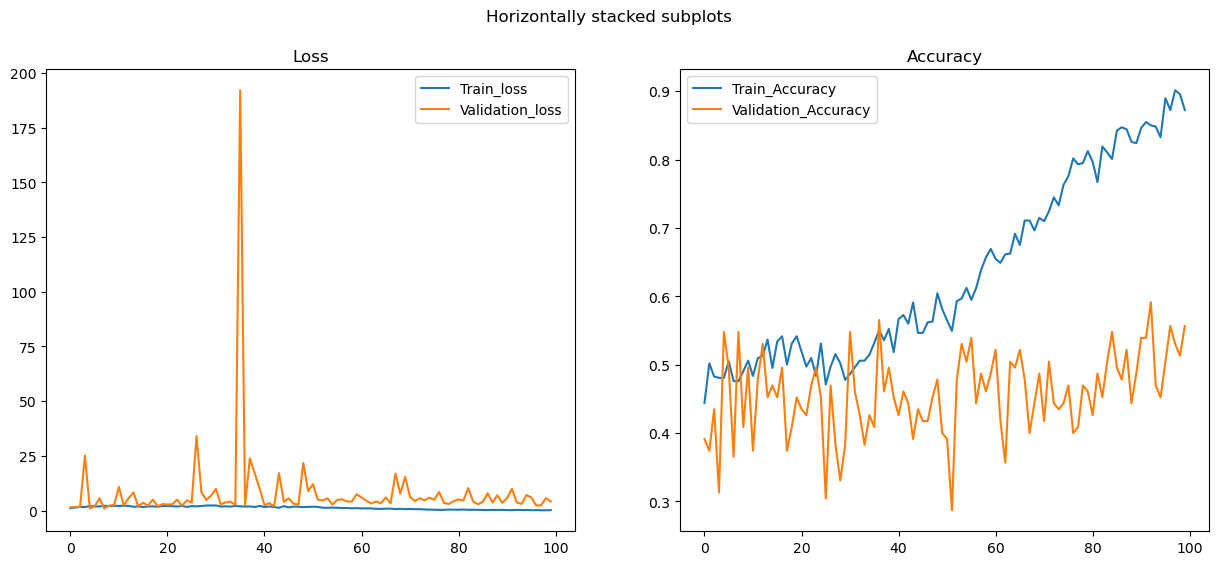

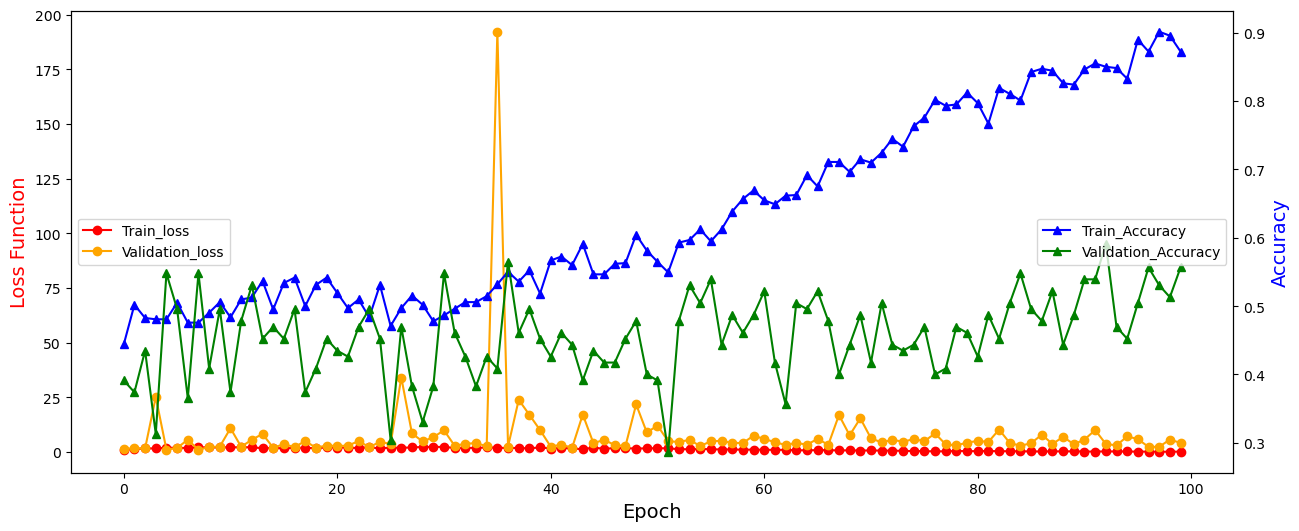

Current time: 198.108 minutes. Time expected till completion: 0.000 minutes
Finished training in: 198.108 minutes


In [17]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [18]:
best_model_val_acc

0.591304347826087

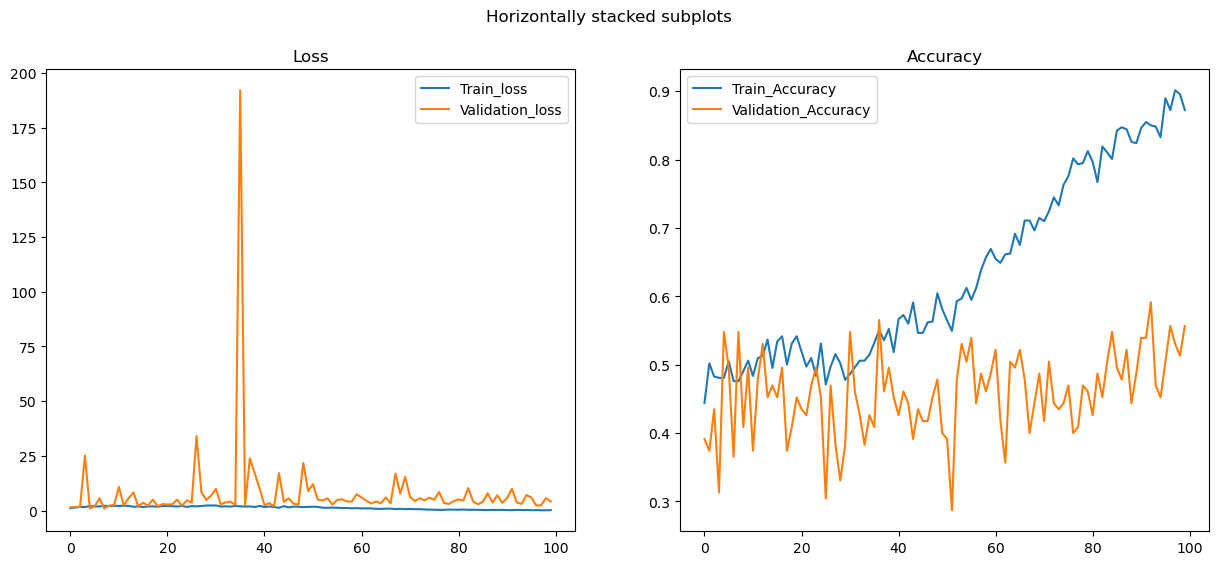

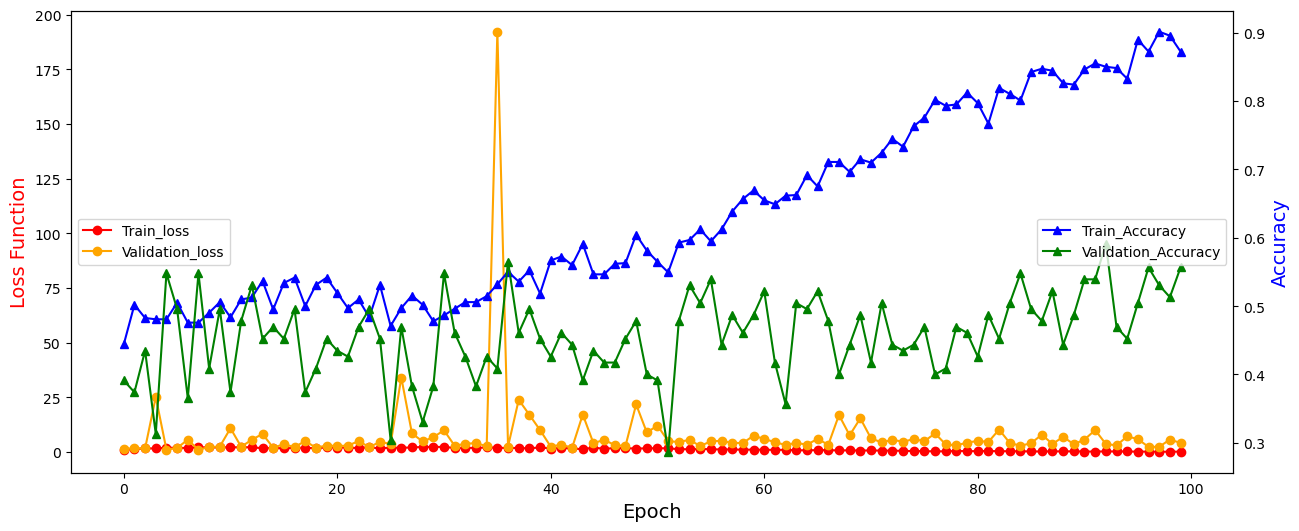

In [19]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [20]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [21]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

## Evaluate Last Model

In [22]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [23]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:37<00:00,  3.45it/s]


Accuracy of the network on the 1034 Train instances: 92.26305609284333%


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]

Accuracy of the network on the 115 Validation instances: 55.65217391304348%


## Test Predictions Last Model

In [24]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [25]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:19<00:00, 19.18it/s]


(array([0, 1, 2, 3]), array([155, 161,  57,   7], dtype=int64))

In [26]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v02_DenseNet_prediction.csv")

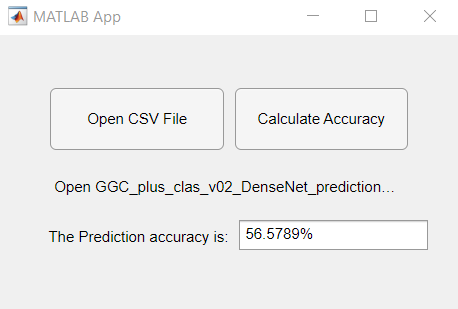

# Load Best Model

In [27]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

## Evaluate Best Model

In [28]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:37<00:00,  3.44it/s]


Accuracy of the network on the 1034 Train instances: 89.55512572533848%


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]

Accuracy of the network on the 115 Validation instances: 59.130434782608695%


## Test Predictions Best Model

In [29]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:19<00:00, 19.97it/s]


(array([0, 1, 2, 3]), array([193, 130,  54,   3], dtype=int64))

In [30]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v02_DenseNet_best_prediction.csv")

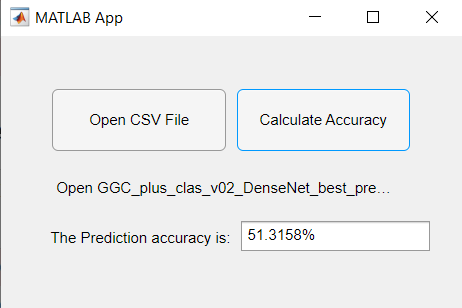